In [ ]:
In this note, we want to mimic measure pulse default of IBM system

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit_ibm_provider import IBMProvider
from qiskit.circuit import Gate, Parameter, QuantumCircuit
from qiskit import pulse, schedule
from qiskit.tools.jupyter import *
from qiskit_ibm_provider.job import job_monitor
from qiskit.pulse import Gaussian
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from qiskit import *

import time
import os
import csv

import warnings
warnings.filterwarnings('ignore')

IBMProvider.save_account('203f29b0bfa35680a0a1045a1eacb1075831a95be4d2bcb1a41b04c0a0aa2890113d94a08a66248a3a8b0820b99de6cdb24e7ac85ed5ce01cb64b6170eea51e8', overwrite=True)
provider = IBMProvider()
backend = provider.get_backend('ibm_brisbane')

In [3]:
backend_defaults = backend.defaults()
backend_properties = backend.properties()
backend_config = backend.configuration()

In [4]:
qubit = 0
f01 = backend.properties().qubits[qubit][2].value * 1e9
anhar = backend.properties().qubits[qubit][3].value * 1e9
f12 = f01 + anhar
pi = np.pi
cos = np.cos
sin = np.sin
exp = np.exp
NUM_SHOTS = 2048
scale_factor = 1e-7
GHz = 1e9
MHz = 1e6

In [5]:
q0_freq = backend_defaults.qubit_freq_est[0]  # Hz
q0_meas_freq = backend_defaults.meas_freq_est[0]  # Hz

print("DriveChannel(0) defaults to a modulation frequency of {} GHz.".format(q0_freq / GHz))
print("MeasureChannel(0) defaults to a modulation frequency of {} GHz.".format(q0_meas_freq / GHz))

DriveChannel(0) defaults to a modulation frequency of 4.721875409363909 GHz.
MeasureChannel(0) defaults to a modulation frequency of 7.175428524047673 GHz.


In [6]:
frequencies = np.linspace(q0_meas_freq-20*MHz, q0_meas_freq+20*MHz, 51)

In [7]:
def get_job_data(job, average):
    """Retrieve data from a job that has already run.
    Args:
        job (Job): The job whose data you want.
        average (bool): If True, gets the data assuming data is an average.
                        If False, gets the data assuming it is for single shots.
    Return:
        list: List containing job result data.
    """
    job_results = job.result()  # timeout parameter set to 120 s
    result_data = []
    for i in range(len(job_results.results)):
        if average:  # get avg data
            result_data.append(np.abs(job_results.get_memory(i)[qubit] * scale_factor))
        else:  # get single data
            result_data.append(job_results.get_memory(i)[:, qubit] * scale_factor)
    return result_data

In [8]:
from qiskit_experiments.library import *
from qiskit_experiments.framework import *
qubit = 0
spec_ground = ResonatorSpectroscopy([qubit], backend, frequencies)

In [9]:
dur12 = 160
sig12 = dur12/4
amp12 = 0.23743549524170637

dur01 = 120
sig01 = dur01/4
amp01 = 0.19784192327828984

In [10]:
#spec_ground.run()

In [11]:
def r12(theta, phi):
    with pulse.build(backend=backend, default_alignment='sequential',
                     name=r'$R^{(12)}$') as r12_pulse:
        drive_chan = pulse.drive_channel(qubit)
        pulse.set_frequency(f12, drive_chan)
        with pulse.phase_offset(-phi, drive_chan):
            pulse.play(pulse.Gaussian(duration=dur12,
                                      amp=amp12*theta/np.pi,
                                      sigma=sig12,
                                      name=r'$X_{\pi/2}^{(12)}$'), drive_chan)

    return r12_pulse
xpi12 = r12(pi, 0)

In [ ]:
We use this schedule to explore measure pulse default of ibm

In [12]:
with pulse.build(backend=backend) as sched:
    meas_chan = pulse.measure_channel(qubit)
    pulse.shift_frequency(0, meas_chan)
    ac_chan = pulse.acquire_channel(qubit)
    mem_chan = pulse.MemorySlot(qubit)
    pulse.measure(0)

In [13]:
sched

ScheduleBlock(ShiftFrequency(0, MeasureChannel(0)), ScheduleBlock(Acquire(1440, AcquireChannel(0), MemorySlot(0)), Play(GaussianSquare(duration=1440, sigma=32, width=1312, amp=0.2385, angle=0.8028318088348103, name='M_m0'), MeasureChannel(0), name='M_m0'), TimeBlockade(6560, AcquireChannel(0)), Delay(6560, MeasureChannel(0)), name="Default measurement schedule for qubits [0]", transform=AlignLeft()), name="block1", transform=AlignLeft())

In [14]:
shift_freq = Parameter("f_shitf")
with pulse.build(backend=backend) as meas_spec_default:
    meas_chan = pulse.measure_channel(qubit)
    pulse.shift_frequency(shift_freq, meas_chan)
    ac_chan = pulse.acquire_channel(qubit)
    mem_chan = pulse.MemorySlot(qubit)
    pulse.acquire(1440, ac_chan, mem_chan)
    pulse.play(pulse.GaussianSquare(amp=0.2385,
                                    duration=1440,
                                    sigma=32,
                                    width=1312), meas_chan)
    pulse.delay(6560, meas_chan)
Spec = Gate("Spectroscopy", 1, [shift_freq])

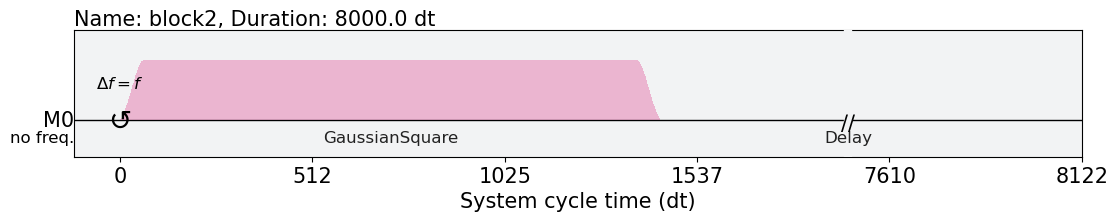

In [15]:
meas_spec_default.draw()

In [40]:
shift_frequencies = np.arange(-5, 5.1, 0.2) * 1e6
len(shift_frequencies), shift_frequencies

(51,
 array([-5.0000000e+06, -4.8000000e+06, -4.6000000e+06, -4.4000000e+06,
        -4.2000000e+06, -4.0000000e+06, -3.8000000e+06, -3.6000000e+06,
        -3.4000000e+06, -3.2000000e+06, -3.0000000e+06, -2.8000000e+06,
        -2.6000000e+06, -2.4000000e+06, -2.2000000e+06, -2.0000000e+06,
        -1.8000000e+06, -1.6000000e+06, -1.4000000e+06, -1.2000000e+06,
        -1.0000000e+06, -8.0000000e+05, -6.0000000e+05, -4.0000000e+05,
        -2.0000000e+05,  4.4408921e-09,  2.0000000e+05,  4.0000000e+05,
         6.0000000e+05,  8.0000000e+05,  1.0000000e+06,  1.2000000e+06,
         1.4000000e+06,  1.6000000e+06,  1.8000000e+06,  2.0000000e+06,
         2.2000000e+06,  2.4000000e+06,  2.6000000e+06,  2.8000000e+06,
         3.0000000e+06,  3.2000000e+06,  3.4000000e+06,  3.6000000e+06,
         3.8000000e+06,  4.0000000e+06,  4.2000000e+06,  4.4000000e+06,
         4.6000000e+06,  4.8000000e+06,  5.0000000e+06]))

In [12]:
'''shift_freq = Parameter("f_shift")
with pulse.build(backend=backend) as meas_spec_default:
    meas_chan = pulse.measure_channel(qubit)
    pulse.shift_frequency(shift_freq, meas_chan)
    ac_chan = pulse.acquire_channel(qubit)
    mem_chan = pulse.MemorySlot(qubit)
    pulse.acquire(960, ac_chan, mem_chan)
    pulse.play(pulse.GaussianSquare(amp=1,
                                    duration=960,
                                    sigma=120,
                                    width=720), meas_chan)
Spec = Gate("Spectroscopy", 1, [shift_freq])'''

In [17]:
Xpi01 = Gate("$X_{\pi}^{01}$", 1, [])
Xpi12 = Gate("$X_{\pi}^{12}$", 1, [])
Meas_gate = Gate("Measure", 1, [shift_freq])

In [18]:
qc_0 = QuantumCircuit(1, 1)
qc_0.append(Spec, [0])
qc_0.add_calibration(Spec, (0, ), meas_spec_default, [shift_freq])
spec_0_circs = [qc_0.assign_parameters({shift_freq: f}, inplace=False) for f in shift_frequencies]

In [19]:
qc_1 = QuantumCircuit(1, 1)
qc_1.x(0)
qc_1.append(Spec, [0])
qc_1.add_calibration(Spec, (0, ), meas_spec_default, [shift_freq])
spec_1_circs = [qc_1.assign_parameters({shift_freq: f}, inplace=False) for f in shift_frequencies]

In [20]:
qc_2 = QuantumCircuit(1, 1)
qc_2.x(0)
qc_2.append(Xpi12, [0])
qc_2.append(Spec, [0])
qc_2.add_calibration(Xpi12, (0, ), xpi12, [])
qc_2.add_calibration(Spec, (0, ), meas_spec_default, [shift_freq])
spec_2_circs = [qc_2.assign_parameters({shift_freq: f}, inplace=False) for f in shift_frequencies]

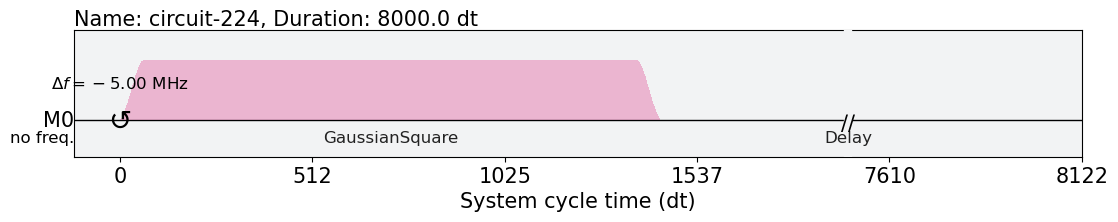

In [21]:
schedule(spec_0_circs[0], backend=backend).draw()

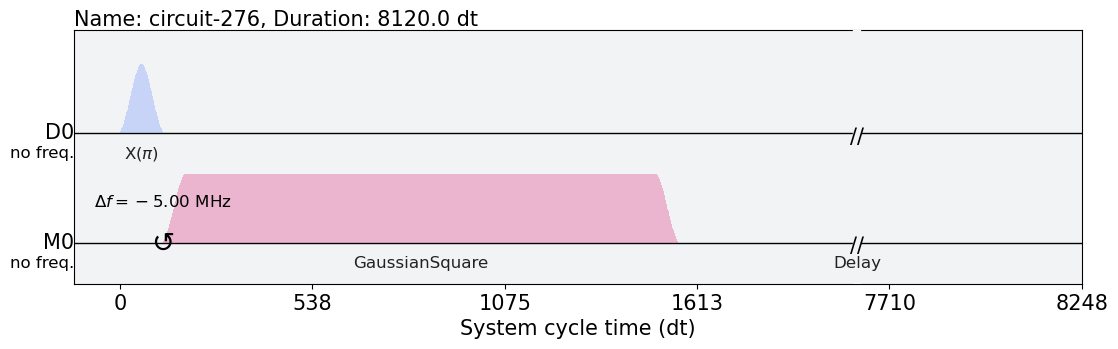

In [22]:
schedule(spec_1_circs[0], backend=backend).draw()

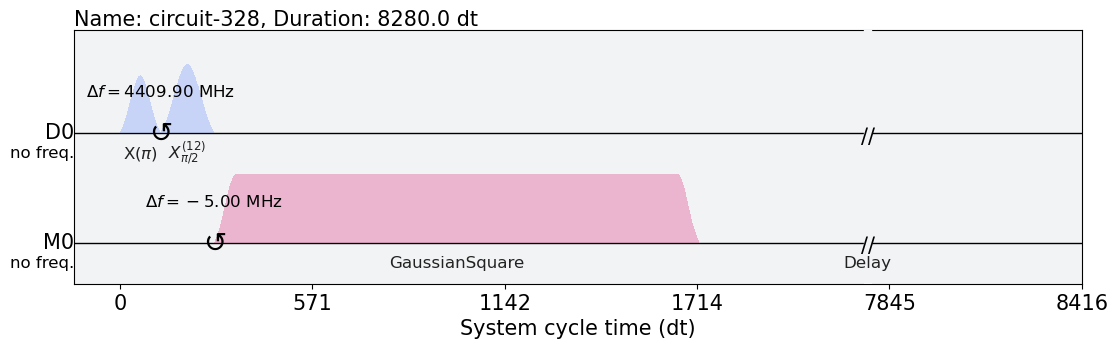

In [23]:
schedule(spec_2_circs[0], backend=backend).draw()

In [26]:
list_ids = []
#spec_circs = ['''spec_0_circs''', spec_1_circs, spec_2_circs]
spec_circs = [spec_1_circs, spec_2_circs]
for circ in spec_circs:
    job = backend.run(circ, meas_level=1, meas_return='single', shots=4096)
    list_ids.append(job.job_id())
    
list_ids

['cnc9esvp253000870m6g', 'cnc9etkrbhc0008j9e7g']

In [53]:
#list_ids = ['cnbtrja0m2gg008c8hfg', 'cnbtrjt0m2gg008c8hg0', 'cnbtrkjrbhc0008j7ha0']
#list_ids = ['cnc6frfrbhc0008j8tjg', 'cnc6fs7hga30008f14yg', 'cnc6fsqrbhc0008j8tk0']
list_ids = ['cnc9esvp253000870m6g', 'cnc9etkrbhc0008j9e7g']
datas = []
for id in list_ids:
    job = provider.backend.retrieve_job(id)
    data = get_job_data(job, average=True)
    datas.append(data)

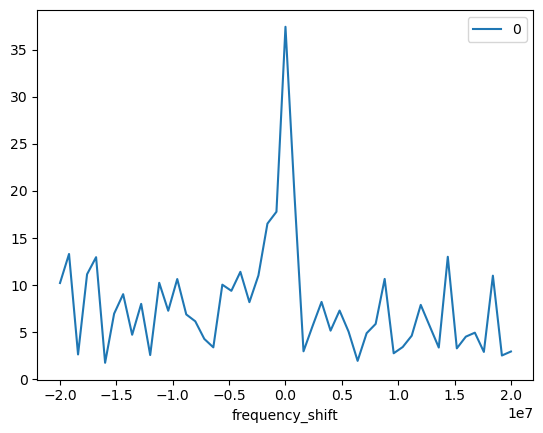

In [66]:
plt.plot(shift_frequencies, datas[0], label='0')
#plt.plot(shift_frequencies, datas[1], label='1')
#plt.plot(shift_frequencies, datas[2], label='2')
plt.xlabel('frequency_shift')
plt.legend()
#plt.savefig('spectro_test_1')

In [25]:
spec_circs_default = spec_ground.circuits()
schedule(spec_circs_default[50], backend=backend)

Schedule((0, ShiftFrequency(20000000, MeasureChannel(0))), (0, Acquire(960, AcquireChannel(0), MemorySlot(0))), (0, Play(GaussianSquare(duration=960, sigma=119.99999999999999, width=720.0, amp=1, angle=0), MeasureChannel(0))), name="circuit-374")

In [29]:
schedule(spec_circs[50], backend=backend)

Schedule((0, Play(Drag(duration=120, sigma=30, beta=-0.005467341849790603, amp=0.19792606011965364, angle=0.0, name='Xp_d0'), DriveChannel(0), name='Xp_d0')), (120, SetFrequency(4409901810.300696, DriveChannel(0))), (120, ShiftPhase(0, DriveChannel(0))), (120, Play(Gaussian(duration=160, sigma=40.0, amp=0.23743549524170637, angle=0, name='$X_{\pi/2}^{(12)}$'), DriveChannel(0), name='$X_{\pi/2}^{(12)}$')), (280, ShiftPhase(0, DriveChannel(0))), (280, ShiftFrequency(20000000.000000037, MeasureChannel(0))), (280, Acquire(960, AcquireChannel(0), MemorySlot(0))), (280, Play(GaussianSquare(duration=960, sigma=120, width=720, amp=1, angle=0), MeasureChannel(0))), name="circuit-427")

In [17]:
job = backend.run(spec_circs, meas_level=1, meas_return='single', shots=4096)

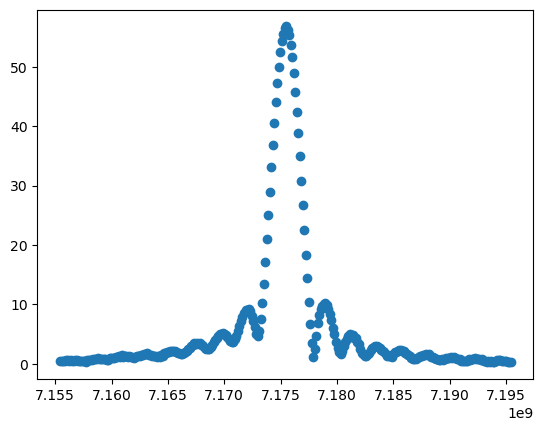

In [34]:
#plt.scatter(frequencies_0, data)
#plt.savefig("spec")
#cnay3740m2gg008c6960

In [18]:
job = provider.backend.retrieve_job("cnbtcy3xswgg0087g4c0")

In [19]:
data = get_job_data(job, average=True)

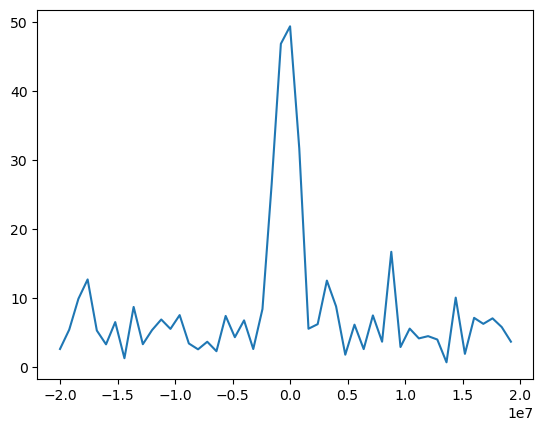

In [21]:
plt.plot(shift_frequencies, data)

In [54]:
datas_single = []
for id in list_ids:
    job = provider.backend.retrieve_job(id)
    data = get_job_data(job, average=False)
    datas_single.append(data)

In [36]:
def reshape_complex_vec(vec):
    """Take in complex vector vec and return 2d array w/ real, imag entries. This is needed for the learning.
    Args:
        vec (list): complex vector of data
    Returns:
        list: vector w/ entries given by (real(vec], imag(vec))
    """
    length = len(vec)
    vec_reshaped = np.zeros((length, 2))
    for i in range(len(vec)):
        vec_reshaped[i] = [np.real(vec[i]), np.imag(vec[i])]
    return vec_reshaped

In [55]:
one_datas = datas_single[0]
two_datas = datas_single[1]

In [37]:
zero_datas = datas_single[0]
one_datas = datas_single[1]
two_datas = datas_single[2]

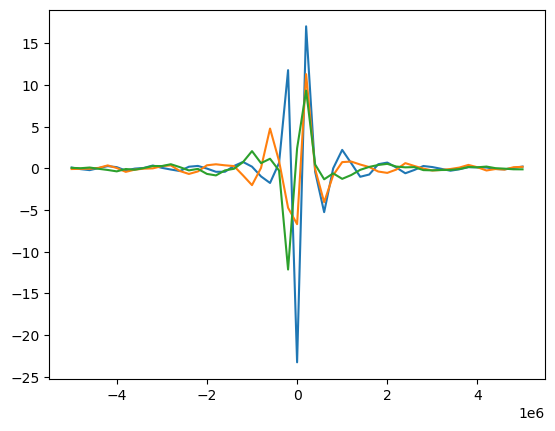

In [50]:
zero_datas_aver = [np.average(data) for data in zero_datas]
one_datas_aver = [np.average(data) for data in one_datas]
two_datas_aver = [np.average(data) for data in two_datas]
plt.plot(shift_frequencies, np.real(np.array(zero_datas_aver)))
plt.plot(shift_frequencies, np.real(np.array(one_datas_aver)))
plt.plot(shift_frequencies, np.real(np.array(two_datas_aver)))

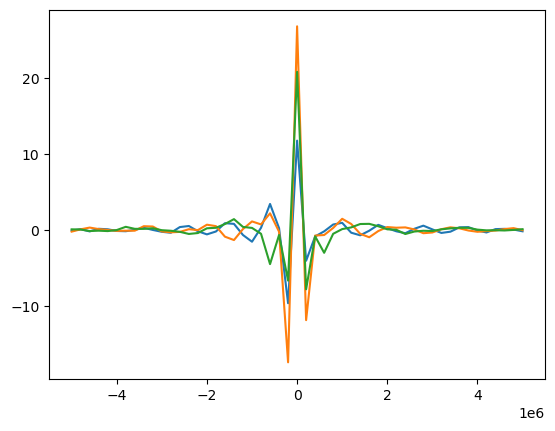

In [52]:
plt.plot(shift_frequencies, np.imag(np.array(zero_datas_aver)))
plt.plot(shift_frequencies, np.imag(np.array(one_datas_aver)))
plt.plot(shift_frequencies, np.imag(np.array(two_datas_aver)))

In [56]:
#zero_datas_reshaped = [reshape_complex_vec(zero_datas[i]) for i in range(51)]
one_datas_reshaped = [reshape_complex_vec(one_datas[i]) for i in range(51)]
two_datas_reshaped = [reshape_complex_vec(two_datas[i]) for i in range(51)]

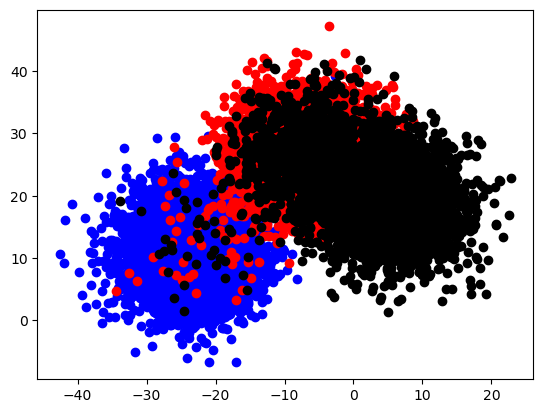

In [67]:
plt.scatter(zero_datas_reshaped[25][:, 0], zero_datas_reshaped[25][:, 1], color='blue', label='0')
plt.scatter(one_datas_reshaped[25][:, 0], one_datas_reshaped[25][:, 1], color='red', label='1')
plt.scatter(two_datas_reshaped[25][:, 0], two_datas_reshaped[25][:, 1], color='black', label='2')

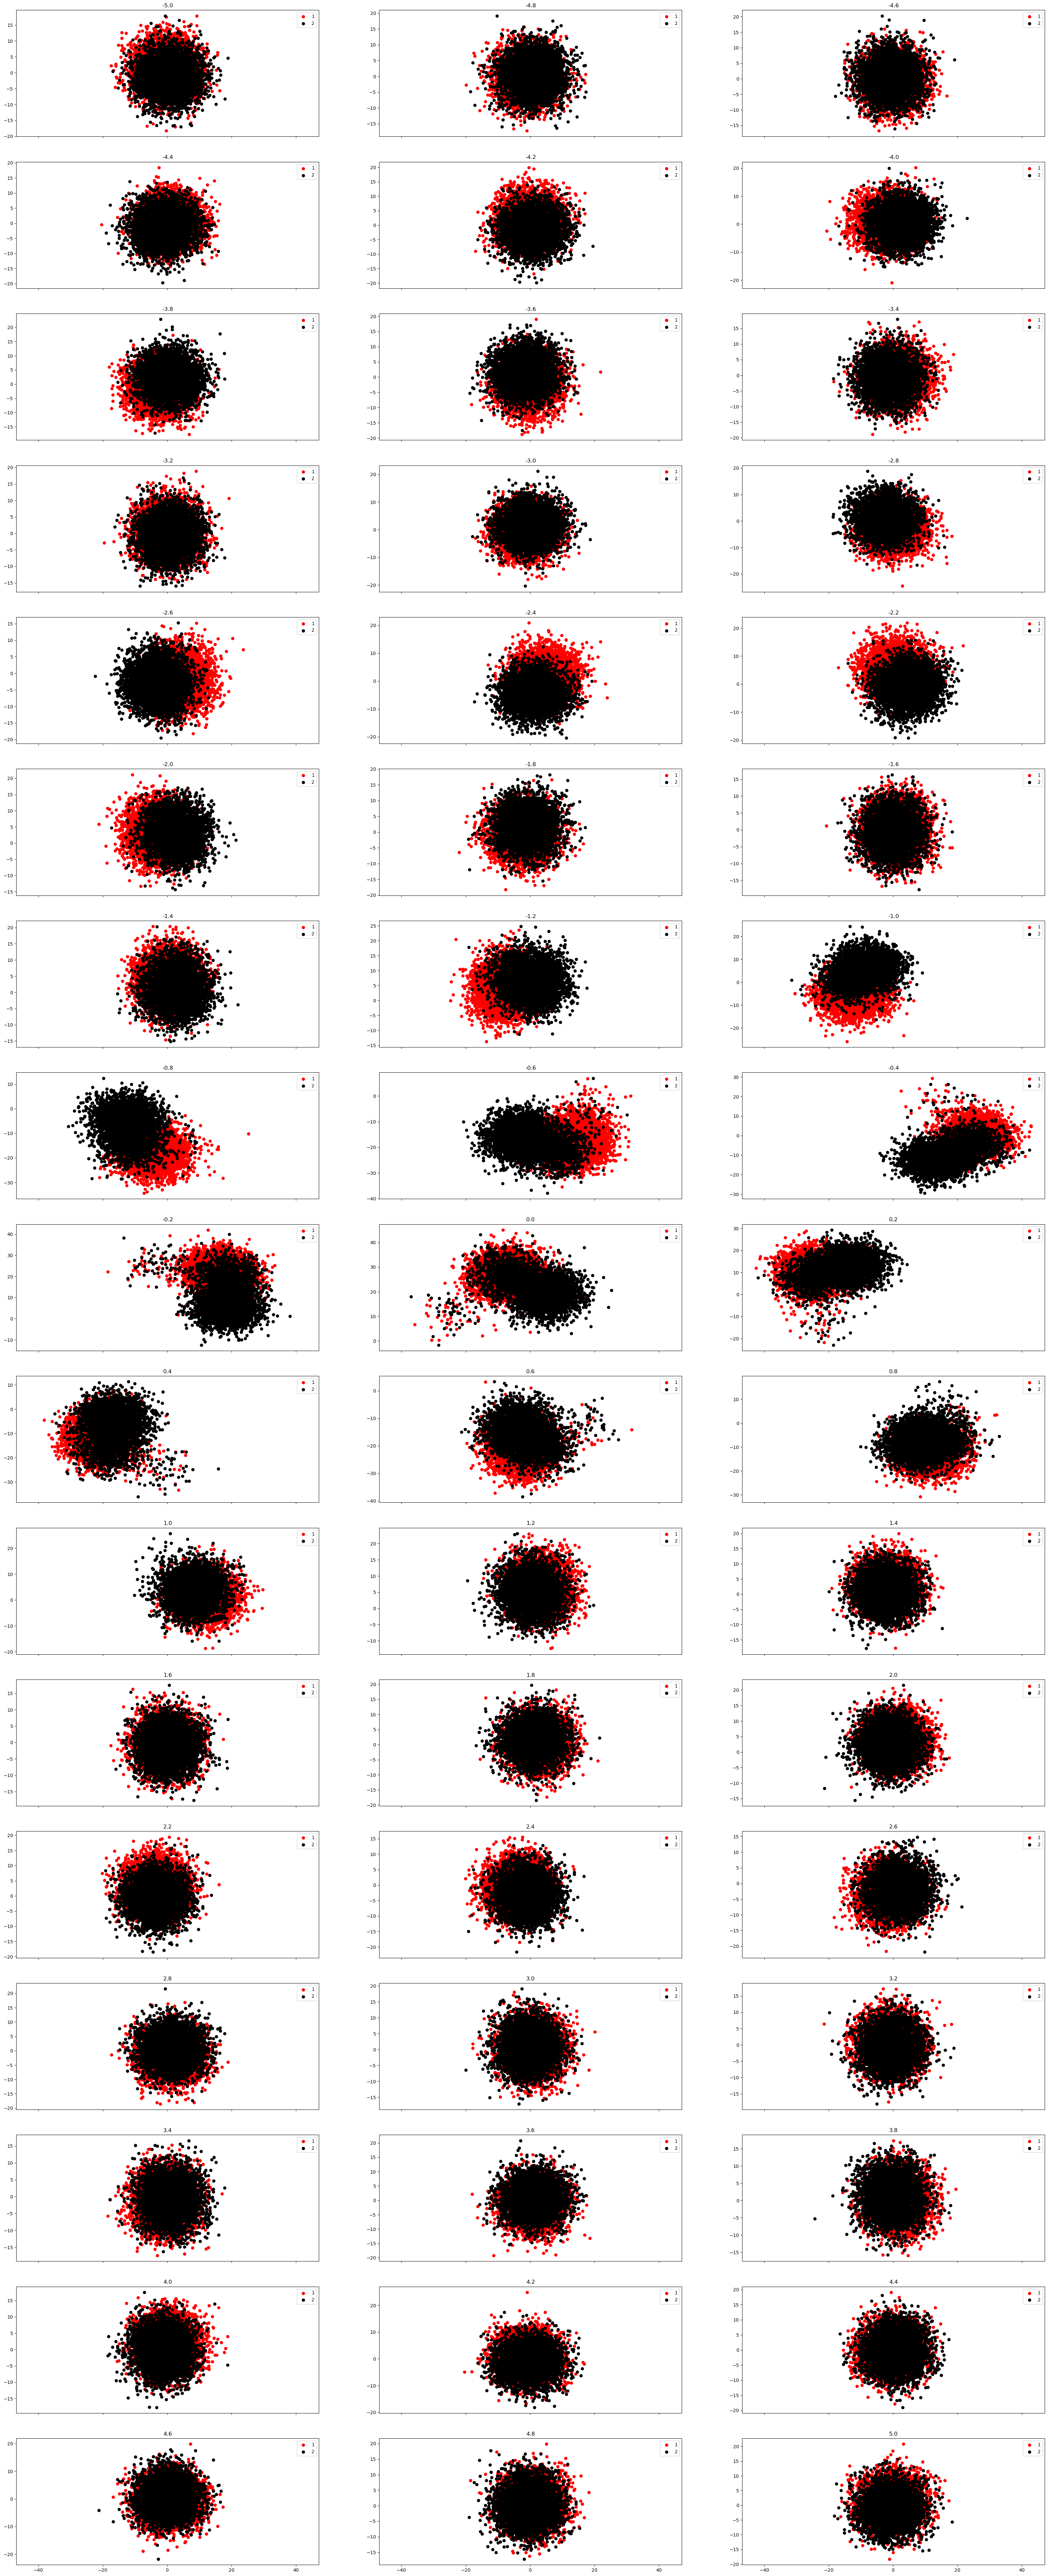

In [57]:
fig, axs = plt.subplots(nrows=17, ncols=3, sharex=True, figsize=(40, 100))
for i in range(17):
    for j in range(3):
        index = 3*i + j
        #axs[i][j].scatter(zero_datas_reshaped[index][:, 0], zero_datas_reshaped[index][:, 1], color='blue', label='0')
        axs[i][j].scatter(one_datas_reshaped[index][:, 0], one_datas_reshaped[index][:, 1], color='red', label='1')
        axs[i][j].scatter(two_datas_reshaped[index][:, 0], two_datas_reshaped[index][:, 1], color='black', label='2')
        axs[i][j].legend()
        axs[i][j].set_title(np.round(shift_frequencies_MHz[index], 1))

In [41]:
shift_frequencies_MHz = shift_frequencies/MHz

In [58]:
fig.savefig("IQ_plane_meas_spec_1_2")

In [ ]:
0 0 1 2
1 0 1 2
2 0 1 2 

In [46]:
def IQ_012_plot(x_min, x_max, y_min, y_max, data):
    """Helper function for plotting IQ plane for 0, 1, 2. Limits of plot given
    as arguments."""
    # zero data plotted in blue
    zero_data = data[0]
    one_data = data[1]
    two_data = data[2]
    alpha = 1
    size = 10
    plt.scatter(np.real(zero_data), np.imag(zero_data),
                s=size, cmap='viridis', c='blue', alpha=alpha, label=r'$|0\rangle$')
    # one data plotted in red
    plt.scatter(np.real(one_data), np.imag(one_data),
                s=size, cmap='viridis', c='red', alpha=alpha, label=r'$|1\rangle$')
    # two data plotted in green
    plt.scatter(np.real(two_data), np.imag(two_data),
                s=size, cmap='viridis', c='green', alpha=alpha, label=r'$|2\rangle$')

    # Plot a large dot for the average result of the 0, 1 and 2 states.
    mean_zero = np.mean(zero_data) # takes mean of both real and imaginary parts
    mean_one = np.mean(one_data)
    mean_two = np.mean(two_data)
    mean_alpha = 1
    mean_size = 100
    plt.scatter(np.real(mean_zero), np.imag(mean_zero),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_one), np.imag(mean_one),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)
    plt.scatter(np.real(mean_two), np.imag(mean_two),
                s=mean_size, cmap='viridis', c='black',alpha=mean_alpha)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min,y_max)
    plt.legend(fontsize=15)
    plt.grid()
    plt.ylabel('I [a.u.]', fontsize=15)
    plt.xlabel('Q [a.u.]', fontsize=15)
    plt.title("0-1-2 discrimination", fontsize=15)


In [63]:
job = provider.backend.retrieve_job("cnc8fxqp253000870ed0")
data = get_job_data(job, average=True)

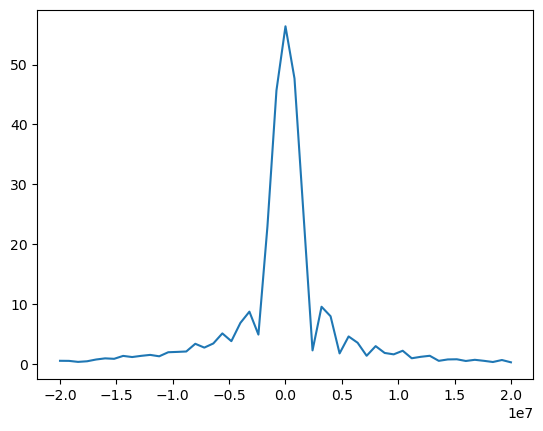

In [65]:
plt.plot(shift_frequencies, data)